In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy


from sklearn.decomposition import PCA

import spacy

nlp = spacy.load('en_core_web_sm')

import joblib

from tqdm.auto import tqdm
from collections import Counter

colors = sns.color_palette("rocket")

In [416]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Topic Classification/medium_data.csv')
df.head(3)

,id,url,title,subtitle,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/not-all-rainbow...,Not All Rainbows and Sunshine: The Darker Side...,Part 1: The Risks and Ethical Issues…,453.0,11,9,Towards Data Science,27-01-2023
1,2,https://towardsdatascience.com/ethics-in-ai-po...,Ethics in AI: Potential Root Causes for Biased...,An alternative approach to understanding bias ...,311.0,3,12,Towards Data Science,27-01-2023
2,3,https://towardsdatascience.com/python-tuple-th...,"Python Tuple, The Whole Truth and Only the Tru...",NaN,188.0,0,24,Towards Data Science,27-01-2023


In [417]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [418]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [419]:
class Text_Tokenization:
  def __init__(self,nlp):
    self.nlp = nlp

  def _spacy_tokenizer(self,doc):
    return [token.lemma_ for token in self.nlp(doc)]

  def tokenize(self,doc,max_len,Vocab = None):
    tokenized_texts = []
    vocab = {}

    if Vocab == None:
      for text in doc:
        tokenized_text = []
        text = self._spacy_tokenizer(text)

        for token_idx,token in enumerate(text):
          if token not in vocab.keys():
            vocab[token] = token_idx

          tokenized_text.append(vocab[token])

        if len(tokenized_text) > max_len:
          tokenized_text = tokenized_text[:max_len]

        elif len(tokenized_text) < max_len:
          while len(tokenized_text) != max_len:
            tokenized_text.append(0)

        tokenized_texts.append(np.array(tokenized_text))

      vocab['<unk>'] = 1
      vocab['<pad>'] = 0
      self.vocab = vocab

      return np.array(tokenized_texts)

    else:
      for text in doc:
        text = self._spacy_tokenizer(text)

        tokenized_text = [Vocab[token] if token in Vocab.keys() else Vocab['<unk>'] for token in text]
        if len(tokenized_text) > max_len:
          tokenized_text = tokenized_text[:max_len]

        elif len(tokenized_text) < max_len:
          while len(tokenized_text) != max_len:
            tokenized_text.append(Vocab['<pad>'])

        tokenized_texts.append(np.array(tokenized_text))

      return np.array(tokenized_texts)

In [420]:
class OneVsRestClassifier:
  def __init__(self,model):
    self.model = model
    self._fit_models = []

  def fit(self,X,y):
    #X = X.values
    #y = y.values
    labels = np.unique(y)

    for label in labels:
      binary_y = np.where(y == label,1,0)

      fit_model = self.model.fit(X,binary_y)
      self._fit_models.append(joblib.dump(fit_model,f'OVA{label}'))

  def predict(self,X):
    predictions = []

    for model_idx,_ in enumerate(self._fit_models):
      model = joblib.load(f'OVA{model_idx}')

      prediction = np.array(model.predict_proba(X)[:,1])
      predictions.append(prediction)

    predictions = np.array(predictions)
    predictions = np.array([predictions[:,element_idx] for element_idx in range(predictions.shape[1])])

    pred_labels = np.argmax(predictions,1)

    return pred_labels

In [421]:
class OneVsOneClassifier:
  def __init__(self,model):
    self.model = model
    self._fit_models = []

  def _most_common(self,y):
    counter = Counter(y)
    value = counter.most_common(1)[0][0]
    return value

  def _hypotesis(self,labels):
    hypotesis = []
    labels = [i for i in range(len(labels))]

    x1 = 0
    x2 = 1

    while x1 <= len(labels) - 2:
      while x2 <= len(labels) - 1:
        hypotesis.append((x1,x2))
        x2 += 1
      x1 += 1
      x2 = x1 + 1

    return hypotesis


  def fit(self,X,y):
    #X = X.values
    #y = y.values

    labels = np.unique(y)

    n = len(labels)

    n_hypotesis = int((n * (n - 1)) / 2)
    self.hypotesis = self._hypotesis(labels)

    for hypotes_idx,hypotes in enumerate(self.hypotesis):

      x1 = labels[hypotes[0]]
      x2 = labels[hypotes[1]]

      idxs = np.array([target_idx for target_idx,target in enumerate(y) if (target == x1 or target == x2)])

      X_train = X[idxs]
      y_train = y[idxs]

      y_train = np.where(y_train == x1,0,1)

      fit_model = self.model.fit(X_train,y_train)
      self._fit_models.append(joblib.dump(fit_model,f'OVO{hypotes_idx}'))


  def predict(self,X):
    predictions = []

    for model_idx,_ in enumerate(self._fit_models):
      model = joblib.load(f'OVO{model_idx}')

      prediction = np.array(model.predict_proba(X)[:,1])
      predictions.append(prediction)

    predictions = np.array(predictions)
    predictions = np.array([predictions[:,element_idx] for element_idx in range(predictions.shape[1])])
    predictions = np.array([np.where(prediction <= 0.5, 0 , 1) for prediction in predictions])

    for prediction_idx,prediction in enumerate(predictions):
      for label_prediction_idx,label_prediction in enumerate(prediction):
        if label_prediction == 0:
          predictions[prediction_idx,label_prediction_idx] = self.hypotesis[label_prediction_idx][0]
        else:
          predictions[prediction_idx,label_prediction_idx] = self.hypotesis[label_prediction_idx][1]

    labels = np.array([self._most_common(classes) for classes in predictions])

    return labels

In [422]:
class Train_Model:
  def __init__(self,model):
    self.model = model
    self._fit_models = []

  def fit(self,X,y):
    ova_model = OneVsRestClassifier(self.model)
    ovo_model = OneVsOneClassifier(self.model)

    ova_model.fit(X,y)
    ovo_model.fit(X,y)

    self._fit_models.append(ova_model)
    self._fit_models.append(ovo_model)

    ova_prediction = ova_model.predict(X)
    ovo_prediction = ovo_model.predict(X)

    ova_acc = accuracy(y,ova_prediction)
    ovo_acc = accuracy(y,ovo_prediction)

    print(f'{self.model} (OneVsRestClassifier) Accuracy on Train Data: {ova_acc}')
    print(f'{self.model} (OneVsOneClassifier) Accuracy on Train Data: {ovo_acc}\n\n')

    return ova_model,ovo_model

  def eval(self,X,y):
    ova_model = self._fit_models[0]
    ovo_model = self._fit_models[1]

    ova_prediction = ova_model.predict(X)
    ovo_prediction = ovo_model.predict(X)

    ova_acc = accuracy(y,ova_prediction)
    ovo_acc = accuracy(y,ovo_prediction)

    print(f'\n{self.model} (OneVsRestClassifier) Accuracy on Test Data: {ova_acc}')
    print(f'{self.model} (OneVsOneClassifier) Accuracy on Test Data: {ovo_acc}')

    if ova_acc == ovo_acc:
      return ova_model,ova_acc

    else:
      highest_score = np.argmax(np.array([ova_acc,ovo_acc]))
      return self._fit_models[highest_score],np.max(np.array([ova_acc,ovo_acc]))

In [423]:
class Optimal_Model:
  def __init__(self,models,X_train,y_train,X_test,y_test):
    self.models = models
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.optimal_models = []
    self.accuracy_scores = []

  def optimal(self):
    for model in self.models:
      print(f'\nModel: {model}')

      Trainer = Train_Model(model)
      Trainer.fit(self.X_train,self.y_train)

      optimal_model,accuracy_score = Trainer.eval(self.X_test,self.y_test)
      self.optimal_models.append(optimal_model)
      self.accuracy_scores.append(accuracy_score)

    highest_acc = np.argmax(np.array(self.accuracy_scores))

    return self.optimal_models[highest_acc]

In [424]:
def Predict(review,model):
  tokenized_review = tokenizer.tokenize([review],max_len = max_len,Vocab = vocab)

  prediction = model.predict(tokenized_review)
  publication = publications[np.array(prediction)[0]]
  
  print(f'{review}: Publication:{publication}')

  return publication

In [425]:
df['text'] = df.title.astype('str') + df.subtitle.astype('str')
df = df[['text','publication']]

publications = df['publication'].unique()


In [426]:
df = df.replace(to_replace = 'Towards Data Science', value = 0)
df = df.replace(to_replace = 'UX Collective', value = 1)
df = df.replace(to_replace = 'The Startup', value = 2)
df = df.replace(to_replace = 'The Writing Cooperative', value = 3)

In [427]:
target_feature = 'publication'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature)

In [428]:
eda.shape()

Number of samples in Data Set: 2498
Number of columns: 2


(2498, 2)

In [429]:
eda.unique_columns()

Unique columns:

Column 1: text
Column 2: publication


Index(['text', 'publication'], dtype='object')

In [430]:
eda.columns_dtypes()

Dtypes:

 text           object
publication     int64
dtype: object


text           object
publication     int64
dtype: object

In [431]:
eda.categorical_features()

Categorical features:

* text


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36939/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36939/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']


array(['text'], dtype='<U4')

In [432]:
eda.numerical_features()

Numerical features: 

* publication


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36939/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36939/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']


array(['publication'], dtype='<U11')

In [433]:
eda.count_NA()

Amout of Nans per class:


text           0
publication    0
dtype: int64

In [434]:
eda.duplicates()
df = df[df.duplicated() == False]

Amount of duplicates: 649


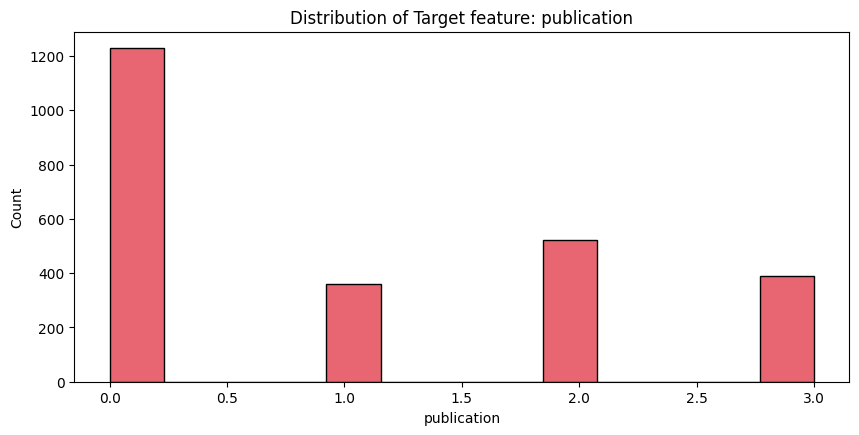

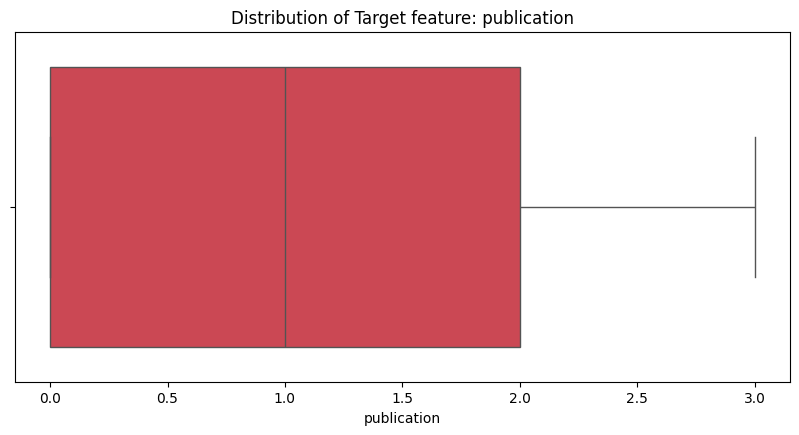

In [435]:
data_visualization.distribution_of_target_feature()

In [436]:
X = df['text'].values
y = df['publication'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [437]:
max_len = 80

tokenizer = Text_Tokenization(nlp)

X_train = tokenizer.tokenize(x_train,max_len = max_len,Vocab = None)
vocab = tokenizer.vocab

X_test = tokenizer.tokenize(x_test,max_len = max_len,Vocab = vocab)

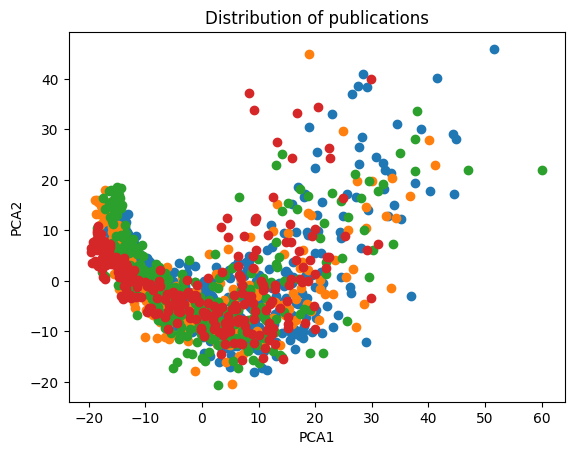

In [438]:
pca = PCA(n_components = 2)

class_one_idxs = np.argwhere(y_train == 0)
class_two_idxs = np.argwhere(y_train == 1)
class_three_idxs = np.argwhere(y_train == 2)
class_four_idxs = np.argwhere(y_train == 3)


class_one = X_train[class_one_idxs].squeeze()
class_two = X_train[class_two_idxs].squeeze()
class_three = X_train[class_three_idxs].squeeze()
class_four = X_train[class_four_idxs].squeeze()


class_one_2d = pca.fit_transform(class_one)
class_two_2d = pca.fit_transform(class_two)
class_three_2d = pca.fit_transform(class_three)
class_four_2d = pca.fit_transform(class_four)


plt.scatter(class_one_2d[:,0],class_one_2d[:,1],label = '0')
plt.scatter(class_two_2d[:,0],class_two_2d[:,1],label = '1')
plt.scatter(class_three_2d[:,0],class_three_2d[:,1],label = '2')
plt.scatter(class_four_2d[:,0],class_four_2d[:,1],label = '3')
plt.title('Distribution of publications')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [439]:
logistic_regression = LogisticRegression()
naive_bayes = GaussianNB()
svc = SVC(probability = True)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
xgb_classifier = XGBClassifier()

models = [logistic_regression,naive_bayes,svc,decision_tree,random_forest,xgb_classifier]

In [440]:
Optimal = Optimal_Model(models,X_train,y_train,X_test,y_test)
optimal_model = Optimal.optimal()


Model: LogisticRegression()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

LogisticRegression() (OneVsRestClassifier) Accuracy on Train Data: 0.5233265720081136
LogisticRegression() (OneVsOneClassifier) Accuracy on Train Data: 0.521974306964165



LogisticRegression() (OneVsRestClassifier) Accuracy on Test Data: 0.4594594594594595
LogisticRegression() (OneVsOneClassifier) Accuracy on Test Data: 0.4540540540540541

Model: GaussianNB()
GaussianNB() (OneVsRestClassifier) Accuracy on Train Data: 0.20081135902636918
GaussianNB() (OneVsOneClassifier) Accuracy on Train Data: 0.1832319134550372



GaussianNB() (OneVsRestClassifier) Accuracy on Test Data: 0.1918918918918919
GaussianNB() (OneVsOneClassifier) Accuracy on Test Data: 0.16486486486486487

Model: SVC(probability=True)
SVC(probability=True) (OneVsRestClassifier) Accuracy on Train Data: 0.5977011494252874
SVC(probability=True) (OneVsOneClassifier) Accuracy on Train Data: 0.5747126436781609



SVC(probability=True) (OneVsRestClassifier) Accuracy on Test Data: 0.5
SVC(probability=True) (OneVsOneClassifier) Accu

In [441]:
review = df['text'].iloc[79]

Predict(review,optimal_model)

5 Reasons to Give Basic Advice as a WriterThe underestimated power of basic advice, and why it should…: Publication:The Writing Cooperative


'The Writing Cooperative'